## Problem Statement

Our firm wants to diversify our portfolio by getting into the real estate business in Ames, Iowa. Like any instrument, we want to know if our return will make the investment worthwhile.

Using available data, build a linear regression model for estimating the sale price of a home, call out which types of attributes are good indicators of value and which detract?

The approach will use Linear Regression, Lasso Regression, and Ridge Regression models as well as Lasso Cross Validation and Ridge Cross Validation for feature selection. Success will be evaluated using $R^2$ and RMSE confidence intervals across 10 folds.

## Data

An original dataset of 2,051 individual residential house sale records from the Ames, Iowa Assessor's office was cleaned and updated in the EDA and Cleaning notebook. Outlier removal left 2,039 records remaining and feature selection, null handling, and dummy variables change the original 78 exploratory variables to 84.

The baseline value is the mean of our target variable `sale price`, a value of \$181,217. The metrics associated with this baseline that our model will try to improve on are:
  *  $R^2$ 0.000
  *  RMSE: 79300

This is calculated below in the [Baseline Stats Section](#baseline)

#### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn import metrics

from statistics import mean, stdev

#### Helper Functions

In [2]:
def r2_adj(model, X, y):
    '''Returns R2_adjusted for a model
       model = instance of model
       X = design matrix
       y = target variable'''
    
    
    r2 = model.score(X,y)
    n = y.size
    k = X.shape[1]
    
    out = 1- ((1-r2)*(n-1)/(n-k-1))
    
    return out

def metrics_everywhere(model, X, y):
    predictions = model.predict(X)

    # r2
    my_r2 = metrics.r2_score(y, predictions)

    # r2_adj
    my_r2_adj = r2_adj(model, X, y)

    # max_error
    my_max_error = metrics.max_error(y, predictions)

    # SSE
    my_sse = y.size*metrics.mean_squared_error(y, predictions,
                               squared = True)

    # MSE
    my_mse = metrics.mean_squared_error(y, predictions,
                               squared = True)

    # RMSE
    my_rmse = metrics.mean_squared_error(y, predictions,
                               squared = False)

    print( "Model Stats\n\nr2: {:.4f}\nr2_adj: {:.4f}\nmax_error: {:.0f}\nSSE: {:.0f}\nMSE: {:.0f}\nRMSE: {:.0f}"\
          .format(my_r2,my_r2_adj,my_max_error,my_sse,my_mse,my_rmse))

    return

In [3]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs, label = 'Actual = Predicted')
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

# source:
# https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates

In [4]:
def print_results(scores_list):
    return f'''
    [min, max] = {[round(min(scores_list), 2), round(max(scores_list), 2)]}
    
    confidence interval: {round(mean(scores_list), 2)} \u00B1 {round(2 * stdev(scores_list), 2)}
    '''

#### Import Data

In [5]:
train = pd.read_csv('datasets/train_cleaned.csv').set_index('pid')

In [6]:
target = 'saleprice'
cols = [col for col in train.columns if col != target]

y = train[target]

X = train[cols]

<a id='baseline'></a>
#### Baseline stats

In [7]:
X['baseline'] = y.describe()['mean']

In [8]:
lr = LinearRegression()
lr.fit(X[['baseline']],y)
metrics_everywhere(lr, X[['baseline']],y)

Model Stats

r2: 0.0000
r2_adj: -0.0005
max_error: 430440
SSE: 12822276879390
MSE: 6288512447
RMSE: 79300


In [9]:
X.drop('baseline', axis = 1, inplace=True)

## Train_Test_Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 21)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1835, 84) (1835,)
(204, 84) (204,)


In [11]:
lr = LinearRegression(n_jobs = -1)

lr.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [12]:
lr.score(X_train, y_train),lr.score(X_test, y_test)

(0.9128415195866887, 0.9147246438212291)

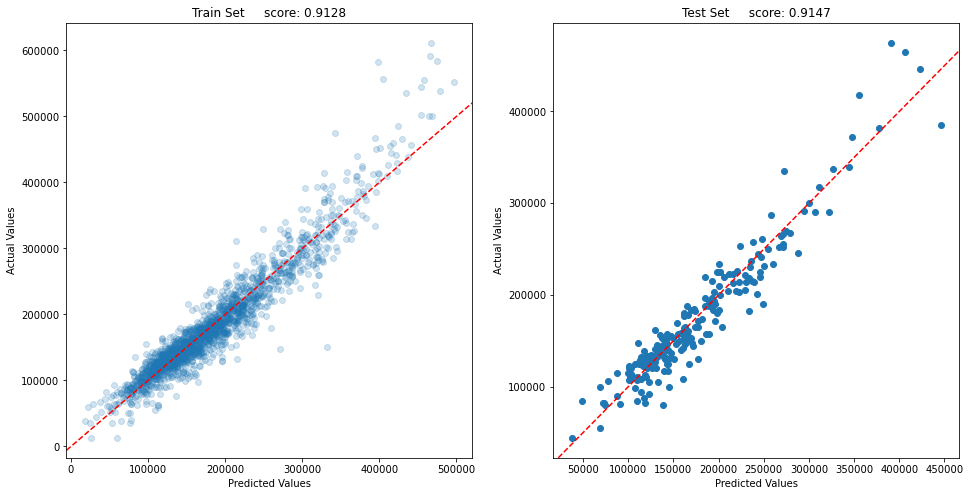

In [13]:
figure, ax = plt.subplots(1, 2, figsize = (16,8))

lr.fit(X_train, y_train)

test_predictions  =  lr.predict(X_test)
test_score        =  round(lr.score(X_test, y_test),4)

train_predictions = lr.predict(X_train)
train_score = round(lr.score(X_train, y_train),4)

# Plot the model
ax[0].scatter(train_predictions, y_train, alpha = 0.2)
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Actual Values")
ax[0].set_title('Train Set'+"     score: " +str(train_score))



# Plot the model
ax[1].scatter(test_predictions, y_test)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Actual Values")
ax[1].set_title('Test Set'+"     score: " +str(test_score));

add_identity(ax[0], color = 'r', ls='--')
add_identity(ax[1], color = 'r', ls='--');

**Interpretation** 
The intial linear regression model from all of the cleaned variables already does a good job at estimating to new data. It should be possible to get a better score through Lasso CV techniques.

In [14]:
metrics_everywhere(lr, X_train, y_train)

Model Stats

r2: 0.9128
r2_adj: 0.9087
max_error: 184672
SSE: 1021589223195
MSE: 556724372
RMSE: 23595


In [15]:
metrics_everywhere(lr, X_test, y_test)

Model Stats

r2: 0.9147
r2_adj: 0.8545
max_error: 84162
SSE: 93119537347
MSE: 456468320
RMSE: 21365


**Observation** The model adapts well to unseen data in a test train split environment, outperforming the train set on r2 as well as RMSE

## Cross Validation

In [16]:
lr_cv = LinearRegression(n_jobs = -1)

scores = cross_val_score(lr_cv, X, y,
                         cv = 10,
                         n_jobs = -1)

RMSE = mean([np.sqrt(-x) for x in cross_val_score(lr_cv, X, y,
                                     cv = 10,
                                     n_jobs = -1,
                                     scoring='neg_mean_squared_error')])


print(print_results(scores))
print(f'RMSE: {round(RMSE,0)}')


    [min, max] = [0.89, 0.92]
    
    confidence interval: 0.9 ± 0.02
    
RMSE: 24473.0


**Observation** Low variance in our model with significant improvement over the baseline RMSE of 79300

## Standard Scale for Lasso and Ridge

In [17]:
ss = StandardScaler()
ss.fit(X)

X_ss = pd.DataFrame(ss.transform(X), columns = X.columns)


## Lasso Regression

In [18]:
lasso = Lasso()

scores_lasso = cross_val_score(lasso, X_ss, y,
                               cv = 10,
                               n_jobs = -1)

RMSE_lasso = mean([np.sqrt(-x) for x in cross_val_score(lasso, X, y,
                                     cv = 10,
                                     n_jobs = -1,
                                     scoring='neg_mean_squared_error')])



print(print_results(scores_lasso))

print(f'RMSE: {round(RMSE_lasso,0)}')



    [min, max] = [0.89, 0.92]
    
    confidence interval: 0.9 ± 0.02
    
RMSE: 24469.0


**Observation** Applying Lasso Regression improves RMSE while maintaining the 95% confidence interval.

## Ridge Regression

In [19]:
ridge = Ridge()

scores_ridge = cross_val_score(ridge, X_ss, y,
                               cv = 10,
                               n_jobs = -1)

RMSE_ridge = mean([np.sqrt(-x) for x in cross_val_score(ridge, X, y,
                                     cv = 10,
                                     n_jobs = -1,
                                     scoring='neg_mean_squared_error')])

print(print_results(scores_ridge))
print(f'RMSE: {round(RMSE_ridge,0)}')


    [min, max] = [0.89, 0.92]
    
    confidence interval: 0.9 ± 0.02
    
RMSE: 24457.0


**Observation** Applying Ridge Regression improves RMSE beyond Lasso Regression while maintaining the 95% confidence interval.

## Ridge CV

In [20]:
# fit RidgeCV
ridge_cv = RidgeCV(cv = 10).fit(X_ss, y)

print(f'best alpha: {round(ridge_cv.alpha_,2)}')
print(f'score: {round(ridge_cv.score(X_ss, y),2)}')

# get ridge columns
new_ridge = Ridge(alpha = ridge_cv.alpha_)
new_ridge.fit(X_ss, y)

final_columns_ridge = [col for col, coef in zip(X_ss.columns, new_ridge.coef_) if coef]
print(f'Starting number of features: {X.shape[1]}')
print(f'Ridge CV number of features: {len(final_columns_ridge)}')

best alpha: 10.0
score: 0.91
Starting number of features: 84
Ridge CV number of features: 83


In [21]:
# use cols in lr
lr_ridge_cv = LinearRegression(n_jobs = -1)

scores3 = cross_val_score(lr_ridge_cv, X_ss[final_columns_ridge], y,
                         cv = 10,
                         n_jobs = -1)

RMSE_lr_ridge = mean([np.sqrt(-x) for x in cross_val_score(lr_ridge_cv, X, y,
                                     cv = 10,
                                     n_jobs = -1,
                                     scoring='neg_mean_squared_error')])


print(print_results(scores3))
print(f'RMSE: {round(RMSE_lr_ridge,0)}')


    [min, max] = [0.89, 0.92]
    
    confidence interval: 0.9 ± 0.02
    
RMSE: 24473.0


**Observation** Ridge CV removes 1 feature but does not show any improvement in the confidence interval or RMSE.

## Lasso CV

In [28]:
# fit LassoCV
lasso_cv = LassoCV(cv = 10).fit(X_ss, y)

print(f'best alpha: {lasso_cv.alpha_}')
print(f'score: {round(lasso_cv.score(X_ss, y),2)}')


# get lasso columns
new_lasso = Lasso(alpha = lasso_cv.alpha_)
new_lasso.fit(X_ss, y)

final_columns_lasso = [col for col, coef in zip(X_ss.columns, new_lasso.coef_) if coef]
print(f'Starting number of features: {X.shape[1]}')
print(f'Lasso CV number of features: {len(final_columns_lasso)}')

best alpha: 257.75915171655816
score: 0.91
Starting number of features: 84
Lasso CV number of features: 57


In [23]:
lr_lasso_cv = LinearRegression(n_jobs = -1)

scores = cross_val_score(lr_lasso_cv, X[final_columns_lasso], y,
                         cv = 10,
                         n_jobs = -1)

RMSE_lr_lasso = mean([np.sqrt(-x) for x in cross_val_score(lr_lasso_cv, X, y,
                                     cv = 10,
                                     n_jobs = -1,
                                     scoring='neg_mean_squared_error')])


print(print_results(scores))
print(f'RMSE: {round(RMSE_lr_lasso,0)}')


    [min, max] = [0.89, 0.92]
    
    confidence interval: 0.91 ± 0.02
    
RMSE: 24473.0


**Observation** Lasso CV removes 27 features and improves the confidence interval without improvement to RMSE

score:  0.9123909921630287


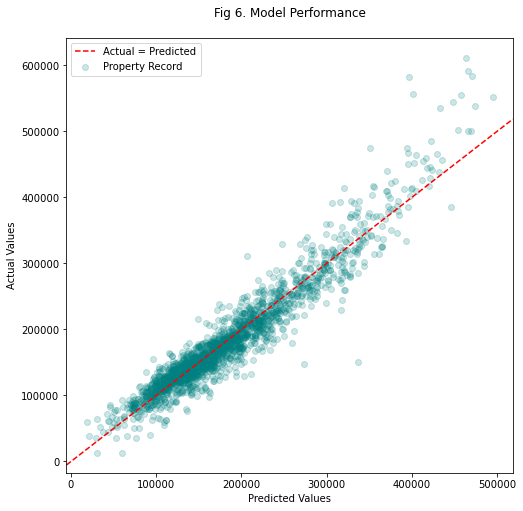

In [24]:
#plot this
lr_lasso_cv.fit(X[final_columns_lasso], y)

predictions  =  lr_lasso_cv.predict(X[final_columns_lasso])
score        =  lr_lasso_cv.score(X[final_columns_lasso], y)

# Plot the model
figure, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(predictions, y, alpha = 0.2, color='teal', label = 'Property Record')
ax.set_title('Fig 6. Model Performance\n')
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")
add_identity(ax, color = 'r', ls='--')
ax.legend()




print("score: ", score)

**Interpretation** Model residuals are clustered on the 0 line (here noted as the 'Actual = Predicted' line). There is some flaring on the upper end of Actual Values indicating some missed signal on those types of sales.

In [29]:
coef_list = pd.Series(lr_lasso_cv.coef_, index = X[final_columns_lasso].columns)

In [26]:
# 10 most positive values
coef_list.sort_values(ascending=False)[:10]

neighborhood_group_3     33341.846428
is_land_countour_hls     17657.621250
bldg_type_1Fam           16531.605990
is_functional            16126.243062
ms_zoning_FV             15864.027626
sale_type_New            14624.713978
overall_qual             11391.681745
garage_new_2006           8895.899167
bsmt_cond_is_TA_Gd_Ex     6784.072487
is_fully_paved_drive      6729.116258
dtype: float64

In [27]:
# 10 most negative values
coef_list.sort_values(ascending=False)[-10:]

garage_finish_RFn       -4115.190755
has_porch               -4318.327320
has_garage              -4455.641493
home_has_remodel        -4546.354144
exterior_has_Plywood    -4680.261624
bedroom_abvgr           -5092.716228
bsmt_qual_Ex_Gd         -5373.841064
exterior_has_HdBoard    -6188.311197
mas_vnr_type_BrkFace    -6556.028712
has_basement           -23216.165012
dtype: float64

**Note** Each of these coefficients indicate the change in `sale price` per unit change of the variable.

Examples:
  *  `has_basement` is an indicator value, so having a basement will decrease the `sale price` by \$23,216
  *  `bedroom_abvgr` represents the number of above grade bedrooms. For every bedroom above grade, the `sale price` decreases by /$5,092 
  
Variable descriptions can be found in the data dictionary of the README

## Conclusions

#### Model overview

The best confidence interval was achieved using the 57 exploratory varibles identified from Lasso cross validation on a Linear Regression model.

The initial model had a 95\% confidence interval of 0.9 ± 0.02 and an RMSE of 24473 dollars.

Our final model improved that confidence interval to 0.91 ± 0.02 with the same RMSE of 24473 dollars.

This higher confidence interval was also the reason why the final model was picked to be the vanilla Linear Regression rather than Lasso or Ridge despite the latter two having lower RMSE values.

#### Results

In answer to the problem statement, in absence of complete data available, the three most positively and negatively affecting variables (in context with their magnitude of units) can be determined:

Three most positively impacting variables:
  *  Membership in Neighborhood Grouping 3
    *  a generated collection of neighborhoods that had a mean sale price one standard deviation above the overal sale price mean.
    *  membership here adds \$33k in expected sale price holding all else constant
  *  Above Grade Living Area (Square Footage):
    *  every 500 sqft adds \$25k in expected sale price holding all else constant
  *  Location in 'Floating Village Residential' zone
    *  houses sold in this zone see a \$15k increase in expected sale price holding all else constant
    *  for context, the second highest-scoring zone is 'Residential Low Density' at \$4k
    
Three most negatively impacting variables:
  *  Presence of a basement
    *  houses with a basement saw a \$23K decrease in expected sale price holding all else constant
  *  Home Age
    *  each year before 2010 that a home was built decreases the expected sale price \$200 holding all else constant
    *  this translates to a \$20K difference for a home over 100 years old
  *  Home Remodels
    *  houses that were remodeled saw a \$3.6K decrease in expected sale price holding all else constant

#### Downfalls

Some downfalls with the current model are with its handling of higher priced homes. A way to limit this exposure would be to focus portfolios on houses in the expected range of \\$100,000 to \$400,000, where our residuals are very close to the true line.

Future analysis into why these higher prices are less accurately predicted is needed.

Another model improvement identified is through log transformation of the predictor variable `sale price`. This could result in a better confidence interval but was not explored due to the difficulty in explaining coefficients to the stakeholders.